# Import necessary libraries

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50)

import geopandas as gpd

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import time

# Download block group data for Ohio from Eviction Lab.
https://data-downloads.evictionlab.org/

In [5]:
evictions_df = pd.read_csv(r'\block-groups.csv')
evictions_df.head(3)

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,...,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,390017701001,2000,7701.1,"Adams County, Ohio",1340.0,15.81,87.0,17.98,525.0,28882.0,...,0.0,1.12,0.0,2.0,2.0,2.30,2.30,0,0,0
1,390017701001,2001,7701.1,"Adams County, Ohio",1340.0,15.81,88.0,17.98,525.0,28882.0,...,0.0,1.12,0.0,1.0,1.0,1.14,1.14,0,0,0
2,390017701001,2002,7701.1,"Adams County, Ohio",1340.0,15.81,88.0,17.98,525.0,28882.0,...,0.0,1.12,0.0,1.0,0.0,0.00,1.13,1,0,0


In [6]:
evictions_df.shape

(157046, 27)

In [7]:
evictions_df['year'].value_counts()

2016    9238
2007    9238
2001    9238
2002    9238
2003    9238
2004    9238
2005    9238
2006    9238
2008    9238
2015    9238
2009    9238
2010    9238
2011    9238
2012    9238
2013    9238
2014    9238
2000    9238
Name: year, dtype: int64

# Trim down evictions_df to just have hamilton county eviction data

In [17]:
ham_co_evictions_df = evictions_df.drop(evictions_df[evictions_df['parent-location']!='Hamilton County, Ohio'].index.tolist())

In [12]:
evictions_df['parent-location'].value_counts()

Cuyahoga County, Ohio      19754
Franklin County, Ohio      15079
Hamilton County, Ohio      11849
Summit County, Ohio         7684
Montgomery County, Ohio     7140
                           ...  
Paulding County, Ohio        289
Monroe County, Ohio          272
Morgan County, Ohio          255
Noble County, Ohio           204
Vinton County, Ohio          204
Name: parent-location, Length: 88, dtype: int64

In [18]:
ham_co_evictions_df['parent-location'].value_counts()

Hamilton County, Ohio    11849
Name: parent-location, dtype: int64

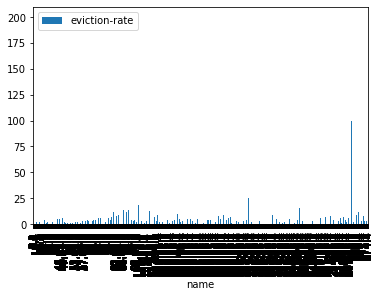

In [24]:
ham_co_evictions_df.plot(kind='hist', x='name', y='eviction-rate')

In [23]:
ham_co_evictions_df.tail()

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
78331,390610274004,2012,274.4,"Hamilton County, Ohio",1560.0,21.81,370.0,73.83,608.0,27313.0,65000.0,32.2,10.9,62.5,23.01,0.0,0.0,0.0,3.59,0.0,51.0,26.0,7.03,13.78,0,0,0
78332,390610274004,2013,274.4,"Hamilton County, Ohio",1560.0,21.81,378.0,73.83,608.0,27313.0,65000.0,32.2,10.9,62.5,23.01,0.0,0.0,0.0,3.59,0.0,53.0,30.0,7.94,14.02,0,0,0
78333,390610274004,2014,274.4,"Hamilton County, Ohio",1560.0,21.81,386.0,73.83,608.0,27313.0,65000.0,32.2,10.9,62.5,23.01,0.0,0.0,0.0,3.59,0.0,67.0,43.0,11.14,17.36,0,0,0
78334,390610274004,2015,274.4,"Hamilton County, Ohio",1560.0,21.81,394.0,73.83,608.0,27313.0,65000.0,32.2,10.9,62.5,23.01,0.0,0.0,0.0,3.59,0.0,49.0,28.0,7.11,12.44,0,0,0
78335,390610274004,2016,274.4,"Hamilton County, Ohio",1560.0,21.81,402.0,73.83,608.0,27313.0,65000.0,32.2,10.9,62.5,23.01,0.0,0.0,0.0,3.59,0.0,45.0,25.0,6.22,11.19,0,0,0


In [21]:
ham_co_evictions_df.describe()

,GEOID,year,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,...,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
count,1.184900e+04,11849.000000,11849.000000,11849.000000,11849.000000,11849.000000,10805.000000,11709.000000,1.157400e+04,10893.000000,...,11849.000000,11849.000000,11849.000000,10455.000000,10455.000000,10455.000000,10455.000000,11849.0,11849.0,11849.0
mean,3.906102e+11,2008.000000,1191.103705,13.383184,200.083720,38.697542,650.826742,52308.563998,1.508256e+05,27.818801,...,0.030028,1.775239,0.172552,20.019895,8.649067,3.954060,9.018618,0.0,0.0,0.0
std,8.335003e+04,4.899186,515.248035,16.518068,185.230303,27.832250,336.556639,31252.339123,1.114481e+05,12.289318,...,0.294624,2.729100,0.620289,31.567371,13.906681,6.207217,11.880513,0.0,0.0,0.0
min,3.906100e+11,2000.000000,142.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,3.906101e+11,2004.000000,828.000000,1.400000,54.000000,14.000000,475.000000,31685.000000,9.050000e+04,21.200000,...,0.000000,0.000000,0.000000,2.000000,1.000000,0.650000,2.950000,0.0,0.0,0.0
50%,3.906102e+11,2008.000000,1106.000000,7.080000,157.000000,36.820000,626.000000,45833.000000,1.190000e+05,26.800000,...,0.000000,1.000000,0.000000,9.000000,4.000000,2.730000,6.830000,0.0,0.0,0.0
75%,3.906102e+11,2012.000000,1467.000000,18.880000,285.000000,59.580000,806.000000,64688.000000,1.721000e+05,34.600000,...,0.000000,2.230000,0.090000,26.000000,11.000000,5.535000,12.110000,0.0,0.0,0.0
max,3.906103e+11,2016.000000,4097.520000,100.000000,1535.000000,100.000000,3074.000000,250001.000000,1.121700e+06,50.100000,...,7.830000,34.550000,9.180000,492.000000,188.000000,200.000000,392.860000,0.0,0.0,0.0


In [26]:
ham_co_evictions_df.sort_values(by='eviction-rate', ascending=False)

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
77746,390610263001,2005,263.1,"Hamilton County, Ohio",344.0,0.00,1.0,0.00,0.00,0.00,0.00,0.00,33.43,66.57,0.00,0.00,0.00,0.00,0.00,0.00,3.0,2.0,200.00,300.00,0,0,0
77743,390610263001,2002,263.1,"Hamilton County, Ohio",641.0,100.00,1.0,50.00,0.00,0.00,0.00,0.00,23.24,71.92,1.72,1.25,0.00,0.16,1.72,0.00,2.0,2.0,200.00,200.00,0,0,0
70357,390610100043,2011,100.04.3,"Hamilton County, Ohio",345.0,0.00,14.0,0.00,NaN,75278.00,202000.00,NaN,18.26,81.74,0.00,0.00,0.00,0.00,0.00,0.00,52.0,25.0,178.57,371.43,0,0,0
70360,390610100043,2014,100.04.3,"Hamilton County, Ohio",345.0,0.00,14.0,0.00,NaN,75278.00,202000.00,NaN,18.26,81.74,0.00,0.00,0.00,0.00,0.00,0.00,55.0,24.0,171.43,392.86,0,0,0
70359,390610100043,2013,100.04.3,"Hamilton County, Ohio",345.0,0.00,14.0,0.00,NaN,75278.00,202000.00,NaN,18.26,81.74,0.00,0.00,0.00,0.00,0.00,0.00,39.0,19.0,135.71,278.57,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78286,390610274002,2001,274.2,"Hamilton County, Ohio",1435.0,13.17,366.0,56.57,399.06,25607.61,66583.55,20.82,84.88,12.82,0.63,0.28,0.42,0.00,0.98,0.00,NaN,NaN,NaN,NaN,0,0,0
78302,390610274003,2000,274.3,"Hamilton County, Ohio",899.0,13.04,170.0,43.48,437.00,30288.00,74900.00,24.70,91.88,3.78,0.67,0.22,0.00,0.00,3.45,0.00,NaN,NaN,NaN,NaN,0,0,0
78303,390610274003,2001,274.3,"Hamilton County, Ohio",899.0,13.04,170.0,43.48,437.00,30288.00,74900.00,24.70,91.88,3.78,0.67,0.22,0.00,0.00,3.45,0.00,NaN,NaN,NaN,NaN,0,0,0
78319,390610274004,2000,274.4,"Hamilton County, Ohio",1197.0,31.40,401.0,76.53,408.00,22863.00,56400.00,22.90,28.65,64.33,3.01,0.33,0.58,0.00,3.01,0.08,NaN,NaN,NaN,NaN,0,0,0


In [30]:
ham_co_2016_df = ham_co_evictions_df[ham_co_evictions_df['year']==2016]

In [36]:
ham_co_2016_df = ham_co_2016_df.drop(ham_co_2016_df[ham_co_2016_df['eviction-rate']>100].index.tolist())

In [37]:
ham_co_2016_df.sort_values(by='eviction-rate',ascending=False)

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
77757,390610263001,2016,263.1,"Hamilton County, Ohio",157.0,0.00,1.0,100.00,NaN,NaN,NaN,NaN,29.30,47.77,0.00,7.64,0.00,0.0,15.29,0.00,1.0,1.0,100.00,100.00,0,0,0
70226,390610100023,2016,100.02.3,"Hamilton County, Ohio",630.0,0.00,257.0,57.33,627.0,26776.0,68400.0,29.8,14.29,84.92,0.79,0.00,0.00,0.0,0.00,0.00,126.0,86.0,33.46,49.03,0,0,0
74102,390610221027,2016,221.02.7,"Hamilton County, Ohio",762.0,0.00,55.0,9.79,NaN,71953.0,129700.0,NaN,44.36,55.64,0.00,0.00,0.00,0.0,0.00,0.00,24.0,14.0,25.45,43.64,0,0,0
66979,390610028002,2016,28.2,"Hamilton County, Ohio",546.0,33.09,196.0,75.44,652.0,25272.0,63800.0,25.5,71.25,27.29,0.00,0.00,0.73,0.0,0.73,0.00,42.0,38.0,19.39,21.43,0,0,0
69818,390610093002,2016,93.2,"Hamilton County, Ohio",725.0,39.88,241.0,88.49,524.0,16571.0,71100.0,30.6,27.72,51.17,19.72,0.00,0.00,0.0,1.38,0.00,73.0,46.0,19.09,30.29,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75156,390610235222,2016,235.22.2,"Hamilton County, Ohio",1242.0,0.00,46.0,5.87,NaN,121155.0,257800.0,NaN,90.98,0.89,0.00,0.00,6.84,0.0,1.29,0.00,0.0,0.0,0.00,0.00,0,0,0
75258,390610236003,2016,236.3,"Hamilton County, Ohio",762.0,7.01,155.0,22.64,741.0,60444.0,131800.0,27.1,99.34,0.00,0.66,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0,0,0
68645,390610063005,2016,63.5,"Hamilton County, Ohio",323.0,0.00,15.0,0.00,NaN,NaN,225000.0,NaN,2.48,82.66,10.22,0.00,0.00,0.0,4.64,0.00,2.0,0.0,0.00,13.33,0,0,0
75292,390610237011,2016,237.01.1,"Hamilton County, Ohio",789.0,3.79,103.0,32.73,888.0,60700.0,122300.0,22.7,86.69,7.60,1.27,0.00,0.00,0.0,1.65,2.79,1.0,0.0,0.00,0.97,0,0,0


In [34]:
type(ham_co_2016_df.loc[66979,'year'])

numpy.int64

# below csv was created from the Hamilton Ccounty, OH auditor's website:
* go to https://wedge3.hcauditor.org/
* select "Advanced" search method
* Under "Land Use Criteria," select 401, 402, and 403.
* Click "search", then save in an appropriate place

In [38]:
apartments_df = pd.read_csv(r'\landlord_search_results_ham_co.csv')

In [50]:
apartments_df.head()

,Parcel Number,Name,Address,Sale Date,Sale Price,full_address
0,001-0001-0018-00,LDN INVESTMENTS LLC,6366 CORBLY RD,7/23/2019,"$340,000","6366 CORBLY RD Hamilton County, Ohio"
1,001-0001-0307-00,SUN VALLEY PROPERTY LLC,6650 CORBLY RD,6/21/2019,NaN,"6650 CORBLY RD Hamilton County, Ohio"
2,001-0001-0359-00,MARKU IV PROPERTIES LLC,6401 COFFEY ST,4/25/2002,"$302,500","6401 COFFEY ST Hamilton County, Ohio"
3,001-0001-0360-00,MARKU IV PROPERTIES LLC,6405 COFFEY ST,4/25/2002,"$302,500","6405 COFFEY ST Hamilton County, Ohio"
4,001-0001-0361-00,JUMP ROBERT A SR & SUZANNE C,6409 COFFEY ST,12/31/1986,$0,"6409 COFFEY ST Hamilton County, Ohio"


In [46]:
apartments_df = apartments_df[apartments_df['Address'].notna()]

In [ ]:
for index, row in apartments_df.iterrows():
    apartments_df.loc[index, 'full_address'] = row['Address'] + " Hamilton County, Ohio"

# Geocode full_address

In [53]:
t1 = time.time()

locator = Nominatim(user_agent='kevin.hengehold@gmail.com')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
apartments_df['location'] = apartments_df['full_address'].apply(geocode)

t_diff = time.time() - t1

print("Elapsed time: ", t_diff, "s")

Elapsed time:  6936.08088850975 s


In [62]:
apartments_df['location'].count()/len(apartments_df['location'])

0.9338628158844765

In [64]:
apartments_df = apartments_df.drop(apartments_df[apartments_df['location'].isna()].index.tolist())

In [65]:
apartments_df['location'].count()/len(apartments_df['location'])

1.0

In [67]:
apartments_df['lat'] = apartments_df['location'].apply(lambda x: x.latitude)
apartments_df['lon'] = apartments_df['location'].apply(lambda x: x.longitude)

apartments_df.head()

,Parcel Number,Name,Address,Sale Date,Sale Price,full_address,location,lat,lon
0,001-0001-0018-00,LDN INVESTMENTS LLC,6366 CORBLY RD,7/23/2019,"$340,000","6366 CORBLY RD Hamilton County, Ohio","(6366, Corbly Road, Mount Washington Business ...",39.094601,-84.380652
1,001-0001-0307-00,SUN VALLEY PROPERTY LLC,6650 CORBLY RD,6/21/2019,NaN,"6650 CORBLY RD Hamilton County, Ohio","(6650, Corbly Road, Mount Washington Business ...",39.094968,-84.372617
2,001-0001-0359-00,MARKU IV PROPERTIES LLC,6401 COFFEY ST,4/25/2002,"$302,500","6401 COFFEY ST Hamilton County, Ohio","(6401, Coffey Street, Beech-Mar, Cincinnati, H...",39.096549,-84.379858
3,001-0001-0360-00,MARKU IV PROPERTIES LLC,6405 COFFEY ST,4/25/2002,"$302,500","6405 COFFEY ST Hamilton County, Ohio","(6405, Coffey Street, Beech-Mar, Cincinnati, H...",39.096541,-84.379695
4,001-0001-0361-00,JUMP ROBERT A SR & SUZANNE C,6409 COFFEY ST,12/31/1986,$0,"6409 COFFEY ST Hamilton County, Ohio","(6409, Coffey Street, Beech-Mar, Cincinnati, H...",39.096532,-84.379530


# Create geoPandas dataframe

In [86]:
geo_apartments_df = gpd.GeoDataFrame(apartments_df, geometry=gpd.points_from_xy(apartments_df.lon, apartments_df.lat))
geo_apartments_df.head()

,Parcel Number,Name,Address,Sale Date,Sale Price,full_address,location,lat,lon,geometry
0,001-0001-0018-00,LDN INVESTMENTS LLC,6366 CORBLY RD,7/23/2019,"$340,000","6366 CORBLY RD Hamilton County, Ohio","(6366, Corbly Road, Mount Washington Business ...",39.094601,-84.380652,POINT (-84.38065 39.09460)
1,001-0001-0307-00,SUN VALLEY PROPERTY LLC,6650 CORBLY RD,6/21/2019,NaN,"6650 CORBLY RD Hamilton County, Ohio","(6650, Corbly Road, Mount Washington Business ...",39.094968,-84.372617,POINT (-84.37262 39.09497)
2,001-0001-0359-00,MARKU IV PROPERTIES LLC,6401 COFFEY ST,4/25/2002,"$302,500","6401 COFFEY ST Hamilton County, Ohio","(6401, Coffey Street, Beech-Mar, Cincinnati, H...",39.096549,-84.379858,POINT (-84.37986 39.09655)
3,001-0001-0360-00,MARKU IV PROPERTIES LLC,6405 COFFEY ST,4/25/2002,"$302,500","6405 COFFEY ST Hamilton County, Ohio","(6405, Coffey Street, Beech-Mar, Cincinnati, H...",39.096541,-84.379695,POINT (-84.37969 39.09654)
4,001-0001-0361-00,JUMP ROBERT A SR & SUZANNE C,6409 COFFEY ST,12/31/1986,$0,"6409 COFFEY ST Hamilton County, Ohio","(6409, Coffey Street, Beech-Mar, Cincinnati, H...",39.096532,-84.379530,POINT (-84.37953 39.09653)


# Import Hamilton County Shapefile.
* download from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [115]:
shapefile_gdf = gpd.read_file(r'\tl_2010_39061_bg10.shp')

In [116]:
shapefile_gdf.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,39,061,004604,1,390610046041,Block Group 1,G5030,S,706969,717,+39.1053497,-084.3869156,"POLYGON ((-84.38513 39.09429, -84.38520 39.094..."
1,39,061,004604,2,390610046042,Block Group 2,G5030,S,1198326,0,+39.1085538,-084.3920240,"POLYGON ((-84.37125 39.09792, -84.37116 39.098..."
2,39,061,004604,3,390610046043,Block Group 3,G5030,S,865435,0,+39.0984588,-084.3782529,"POLYGON ((-84.37590 39.10290, -84.37664 39.100..."
3,39,061,025104,2,390610251042,Block Group 2,G5030,S,6255947,406021,+39.0505781,-084.3783679,"POLYGON ((-84.39665 39.04577, -84.39778 39.045..."
4,39,061,004605,2,390610046052,Block Group 2,G5030,S,3550523,128855,+39.0968292,-084.4033598,"POLYGON ((-84.40183 39.08740, -84.40193 39.087..."


In [103]:
geo_apartments_df.crs = 'EPSG:4269'  #'NAD83'

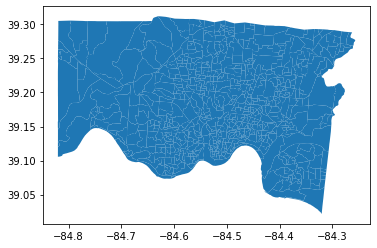

In [117]:
shapefile_gdf.plot()

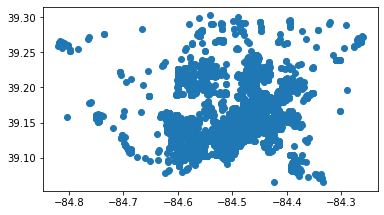

In [114]:
geo_apartments_df.plot()

In [109]:
geo_apartments_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [110]:
shapefile_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [104]:
geo_apartments_df.keys()

Index(['Parcel Number', 'Name', 'Address', 'Sale Date', 'Sale Price',
       'full_address', 'location', 'lat', 'lon', 'geometry'],
      dtype='object')

In [105]:
shapefile_gdf.keys()

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [118]:
apt_joined_gdf = gpd.sjoin(shapefile_gdf,geo_apartments_df, how='inner', op='intersects')  #

In [122]:
apt_joined_gdf.sample(4)

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,index_right,Parcel Number,Name,Address,Sale Date,Sale Price,full_address,location,lat,lon
432,39,061,023222,1,390610232221,Block Group 1,G5030,S,1185957,0,+39.2145453,-084.4390741,"POLYGON ((-84.42636 39.21750, -84.43552 39.217...",6909,671-0020-0024-00,MORGAN LAKESHORE APARTMENTS LLC,LAKESHORE DR,2/3/2014,$0,"LAKESHORE DR Hamilton County, Ohio","(Lakeshore Drive, Lakeshore Apartments, Readin...",39.210862,-84.441885
383,39,061,023800,3,390610238003,Block Group 3,G5030,S,341046,0,+39.1977768,-084.4068797,"POLYGON ((-84.40979 39.19449, -84.40973 39.195...",6244,602-0009-0061-00,KELLER RENA & GEORGE BEKIARIS,3857 GARDNER AVE,3/29/2007,$0,"3857 GARDNER AVE Hamilton County, Ohio","(3857, Gardner Avenue, Amity, Deer Park, Hamil...",39.200029,-84.404381
11,39,061,000900,1,390610009001,Block Group 1,G5030,S,136091,0,+39.1116424,-084.5182760,"POLYGON ((-84.52056 39.11134, -84.52067 39.111...",1275,081-0004-0108-00,RACE STREET TENANT ORGANIZATION COOPERATIVE,1424 REPUBLIC ST,1/1/1990,$0,"1424 REPUBLIC ST Hamilton County, Ohio","(1424, Republic Street, Brewery District, Over...",39.110833,-84.516139
410,39,061,027100,4,390610271004,Block Group 4,G5030,S,260846,0,+39.1946266,-084.4572506,"POLYGON ((-84.46055 39.19250, -84.46070 39.192...",2334,117-0009-0076-00,SHOCKLEY O LYNZI,1845 SECTION RD,9/27/1990,"$84,000","1845 SECTION RD Hamilton County, Ohio","(1845, Section Road, Golf Manor, Hamilton Coun...",39.196934,-84.455336


In [124]:
apt_joined_gdf['GEOID10'].value_counts()

390610083001    116
390610102015     80
390610110001     77
390610057024     71
390610059001     65
               ... 
390610221027      1
390610252005      1
390610237013      1
390610231002      1
390610250024      1
Name: GEOID10, Length: 513, dtype: int64

In [128]:
ham_co_2016_df.head()

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
66503,390610002001,2016,2.1,"Hamilton County, Ohio",917.0,55.56,538.0,100.00,603.0,16620.0,NaN,36.6,3.16,92.26,1.42,0.0,0.00,0.0,2.84,0.33,78.0,31.0,5.76,14.50,0,0,0
66520,390610007001,2016,7.1,"Hamilton County, Ohio",305.0,0.00,94.0,100.00,1177.0,58393.0,NaN,23.2,42.30,47.87,6.56,0.0,1.31,0.0,1.97,0.00,1.0,1.0,1.06,1.06,0,0,0
66537,390610007002,2016,7.2,"Hamilton County, Ohio",854.0,0.00,1082.0,99.25,871.0,61477.0,NaN,21.0,72.72,11.59,4.80,0.0,9.60,0.0,1.29,0.00,18.0,11.0,1.02,1.66,0,0,0
66554,390610007003,2016,7.3,"Hamilton County, Ohio",551.0,0.00,439.0,84.36,1034.0,90962.0,305000.0,17.2,76.95,5.26,10.71,0.0,5.99,0.0,1.09,0.00,9.0,6.0,1.37,2.05,0,0,0
66571,390610009001,2016,9.1,"Hamilton County, Ohio",463.0,57.14,185.0,80.49,598.0,20703.0,391700.0,49.3,50.11,46.22,1.30,0.0,0.00,0.0,2.38,0.00,10.0,7.0,3.78,5.41,0,0,0


In [129]:
geoid = 390610002001
ham_co_2016_df[ham_co_2016_df['GEOID'] == geoid]['eviction-rate']

66503    5.76
Name: eviction-rate, dtype: float64

In [ ]:
len(ham_co_evictions)

In [135]:
geoid

'390610106001'

In [138]:
ham_co_2016_df[ham_co_2016_df['GEOID' == 390610002001]]

KeyError: False

In [139]:
ham_co_2016_df['GEOID'].describe()

count    6.960000e+02
mean     3.906102e+11
std      8.342391e+04
min      3.906100e+11
25%      3.906101e+11
50%      3.906102e+11
75%      3.906102e+11
max      3.906103e+11
Name: GEOID, dtype: float64

In [143]:
apt_geoid = apt_joined_gdf['GEOID10'].apply(lambda x: int(x))

In [147]:
apt_geoid = apt_geoid.drop_duplicates()

In [148]:
ham_co_geoid = ham_co_2016_df['GEOID'].unique()

In [150]:
overlapping = [geoid for geoid in apt_geoid if geoid in ham_co_geoid]



In [151]:
len(overlapping)

513

In [152]:
len(ham_co_geoid)

696

In [153]:
len(apt_geoid)

513

# Add local eviction rate and eviction filing rate to the dataframe

In [174]:
eviction_rate = []
eviction_filing_rate = []

for geoid in apt_joined_gdf['GEOID10']:
    er = ham_co_2016_df[ham_co_2016_df['GEOID'] == int(geoid)]['eviction-rate'].values[0]
    efr = ham_co_2016_df[ham_co_2016_df['GEOID'] == int(geoid)]['eviction-filing-rate'].values[0]
    eviction_rate.append(er)
    eviction_filing_rate.append(efr)
    
apt_joined_gdf['eviction-rate'] = eviction_rate
apt_joined_gdf['eviction-filing-rate'] = eviction_filing_rate


In [178]:
apt_joined_gdf.sample(5)

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,index_right,Parcel Number,Name,Address,Sale Date,Sale Price,full_address,location,lat,lon,eviction-rate,eviction-filing-rate
489,39,061,010100,3,390610101003,Block Group 3,G5030,S,576788,0,+39.1501248,-084.6034033,"POLYGON ((-84.60456 39.15487, -84.60448 39.155...",4087,211-0070-0018-00,RIVERA RADAMES & JAVONNA A,3144 MONTANA AVE,11/3/2017,"$118,900","3144 MONTANA AVE Hamilton County, Ohio","(3144, Montana Avenue, Westwood Town Center Hi...",39.149112,-84.605672,5.06,9.49
656,39,061,005301,2,390610053012,Block Group 2,G5030,S,412505,0,+39.1539079,-084.4272971,"POLYGON ((-84.42524 39.15038, -84.42601 39.150...",683,050-0002-0225-00,BLANTON LARRY W,4222 APPLETON ST,12/1/1986,$0,"4222 APPLETON ST Hamilton County, Ohio","(4222, Appleton Street, Oakley Business Distri...",39.155114,-84.428875,1.70,2.27
328,39,061,005600,5,390610056005,Block Group 5,G5030,S,312667,0,+39.1530369,-084.3843338,"POLYGON ((-84.37974 39.15093, -84.37971 39.150...",312,037-0002-0352-00,HOUSING NETWORK OF HAMILTON COUNTY INC,6750 BRAMBLE AVE,5/7/2020,"$996,485","6750 BRAMBLE AVE Hamilton County, Ohio","(6750, Bramble Avenue, Madisonville, Cincinnat...",39.150978,-84.380971,5.21,7.29
100,39,061,026900,1,390610269001,Block Group 1,G5030,S,297833,0,+39.1201335,-084.5332236,"POLYGON ((-84.53284 39.12296, -84.53288 39.122...",3470,184-0005-0141-00,MRT REAL ESTATE INC,1025 DAYTON ST,11/13/2013,$0,"1025 DAYTON ST Hamilton County, Ohio","(1025, Dayton Street, Dayton Street Historic D...",39.118418,-84.532198,4.81,11.76
656,39,061,005301,2,390610053012,Block Group 2,G5030,S,412505,0,+39.1539079,-084.4272971,"POLYGON ((-84.42524 39.15038, -84.42601 39.150...",691,050-0005-0050-00,ROBINSON LEE G TR,3243 BACH AVE,9/19/1991,$0,"3243 BACH AVE Hamilton County, Ohio","(3243, Bach Avenue, Oakley Business District, ...",39.152686,-84.425231,1.70,2.27


In [179]:
apt_joined_gdf.to_excel(r'\apartments and eviction rates in census blocks.xlsx')